In [1]:
import scipy
import numpy as np
import networkx as nx
import ot
import time
import multiprocessing as mp
from tqdm import tqdm, trange
import torch
import cvxpy as cp
import torch.nn as nn
from torch.optim import Adam, SGD
import matplotlib.pyplot as plt
from dataset import *
from models import *
import h5py

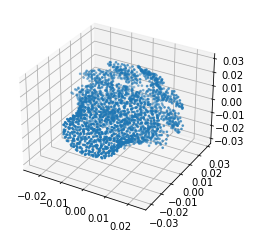

In [2]:
# Load testing data

filename = '/data/sam/modelnet/data/modelnet40_ply_hdf5_2048/ply_data_train1.h5'
dataset = None
labels = None
with h5py.File(filename,'r') as h5f: 
    dataset = h5f['data'][:]
    labels = h5f['label'][:]
    
dataset = dataset - np.expand_dims(np.mean(dataset, axis=0), 0)  # center
dist = np.max(np.sqrt(np.sum(dataset ** 2, axis=1)), 0)
dataset = dataset / dist  # scale

f = open('/data/sam/modelnet/data/shape_names.txt')
lbl_names = f.readlines()

import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(dataset[208][:, 0], dataset[208][:, 1], dataset[208][:, 2], s=3)

In [3]:
#Prepare test dataset
import time
P_test = []
Q_test = []
dists_test = []
nmin = 10
nmax = 200
all_points = dataset[1040]
raw_emd = []
shtime = []
shs = []
for i in trange(200):
    psz = np.random.randint(low=nmin, high=nmax)
    qsz = np.random.randint(low=nmin, high=nmax)
    
    P = all_points[np.random.randint(low=0, high=2048, size=psz)]
    Q = all_points[np.random.randint(low=0, high=2048, size=qsz)]
    mat = ot.dist(P, Q, metric='euclidean')
    p = (1/psz) * np.ones(psz)
    q = (1/qsz) * np.ones(qsz)
    dist = ot.emd2(p, q, mat)
    P_test.append(torch.tensor(P, dtype=torch.float32))
    Q_test.append( torch.tensor(Q, dtype=torch.float32))
    dists_test.append(dist)


100%|██████████| 200/200 [00:00<00:00, 666.75it/s]


In [14]:
shtime = []
shs = []
P_test =[]
Q_test = []
dists_test = []
for i in trange(30):
    psz = 5000
    qsz = 5000
    
    P = all_points[np.random.randint(low=0, high=2048, size=psz)]
    Q = all_points[np.random.randint(low=0, high=2048, size=qsz)]
    mat = ot.dist(P, Q, metric='euclidean')
    p = (1/psz) * np.ones(psz)
    q = (1/qsz) * np.ones(qsz)
    
    start = time.time()
    sh = ot.sinkhorn2(p, q, mat, reg=3.0)
    end = time.time()
    dist = ot.emd2(p, q, mat)
    shs.append(abs(sh-dist)/dist)
    
    shtime.append(end - start)
    P_test.append(torch.tensor(P, dtype=torch.float32))
    Q_test.append(torch.tensor(Q, dtype=torch.float32))
    dists_test.append(dist)
print("average", np.mean(shtime), "std dev", np.std(shtime))
print("average", np.mean(shs), "std dev", np.std(shs))

100%|██████████| 30/30 [01:56<00:00,  3.88s/it]

average 0.8135583639144898 std dev 0.03709801515880551
average 24.534481939259614 std dev 1.8343001813076107


In [92]:
print("average", np.mean(shtime), "std dev", np.std(shtime))

average 4.322709083557129 std dev 0.8316484791383189


In [82]:
shs = np.array(shs)
emds = np.array(dists_test)
errs = abs(shs - emds)/emds
print(np.mean(errs), np.std(errs))

24.19717745413585 1.9470141536861683


In [2]:
load_train_dataset = np.load('/data/sam/modelnet/data/train-datasets/item-2047-pairs-30.npz',allow_pickle=True)
Ps = load_train_dataset['P']
Qs = load_train_dataset['Q']
dists = load_train_dataset['dists']

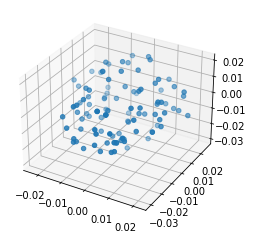

In [7]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(P_test[0][:, 0], P_test[0][:, 1], P_test[0][:, 2])


In [16]:
P_test = Ps[:10].tolist()
Q_test = Qs[:10].tolist()
dists_test = dists[:10]

NameError: name 'Ps' is not defined

In [4]:
# load non-final mlp models
from train import *
device = torch.device('cpu')
in_dim = 3
h_out = [20, 40, 60, 80]
h_layers = [4, 6, 8]
g_out = [1]
g_layers = [1]
models = []
# (h_out, h_layers, g_out, g_layers)
model_params = []
for h in h_out:
    for hl in h_layers:
        for g in g_out:
            for gl in g_layers:
                model_params.append((h, hl, g, gl))
                model_name = generate_name(in_dim, h, g, hl, gl, False, 'sigmoid')
                PATH = '/data/sam/modelnet/models/siamese/1040/l2-{modelname}.pt'.format(modelname=model_name)
                model = PointNetLearner(in_dim, h, g, num_h_layers=hl, 
                            num_g_layers=gl, final_mlp=False, activation='sigmoid')
                model.load_state_dict(torch.load(PATH, map_location=device))
                models.append(model)
 

In [5]:
for model in models:
    timing = []
    for i in range(len(P_test)):
        P = P_test[i].to(device)
        Q = Q_test[i].to(device)
        start = time.time()
        pvec = model.get_embedding(P)
        qvec = model.get_embedding(Q)
        torch.norm(pvec-qvec)
        end = time.time()
        timing.append(end - start)
    print("average", np.mean(timing), "std", np.std(timing))

average 0.0006694185733795166 std 0.00018177421803932517
average 0.0008451986312866211 std 0.00021643655808066496
average 0.001092357635498047 std 0.0005520482242373716
average 0.0007860660552978516 std 0.0002542233585496329
average 0.001025512218475342 std 0.0003527588188312912
average 0.001287081241607666 std 0.0005660571980324222
average 0.000930091142654419 std 0.0009615860582381357
average 0.001106271743774414 std 0.0002721490661376299
average 0.0014520180225372314 std 0.00047259590631152585
average 0.0007025980949401855 std 0.0002863868105240546
average 0.0009335589408874512 std 0.00024123847052719995
average 0.0012712597846984864 std 0.0004386428684069183


In [6]:
all_results = []
average_errors = []
for k in trange(len(models)):
    model = models[k]
    results = []
    model.eval()
    timing = []
    for i in range(len(P_test)):
        P = P_test[i].to(device)
        Q = Q_test[i].to(device)
        dist = dists_test[i]
        pvec = model.get_embedding(P).detach().numpy()
        qvec = model.get_embedding(Q).detach().numpy()
        #print(np.linalg.norm(pvec - qvec, ord=1), dist)
        results.append(abs(np.linalg.norm(pvec - qvec, ord=2)- dist)/dist)
    all_results.append(results)
    avg_error = np.average(results)
    std = np.std(results)
    average_errors.append(avg_error)
    print("Model index:", k ,"Model parameters:", model_params[k], "Average error:", avg_error, "std. dev:", std )
print("Lowest AVERAGE ERROR:", np.argmin(average_errors))

 17%|█▋        | 2/12 [00:00<00:01,  7.36it/s]

Model index: 0 Model parameters: (20, 4, 1, 1) Average error: 1312.9035469154426 std. dev: 874.4389084393688
Model index: 1 Model parameters: (20, 6, 1, 1) Average error: 1295.4341726963573 std. dev: 862.7219594605077


 33%|███▎      | 4/12 [00:00<00:01,  6.51it/s]

Model index: 2 Model parameters: (20, 8, 1, 1) Average error: 1643.9623264904994 std. dev: 1094.7789899096672
Model index: 3 Model parameters: (40, 4, 1, 1) Average error: 2423.2798212325647 std. dev: 1613.0156113317253


 42%|████▏     | 5/12 [00:00<00:01,  6.04it/s]

Model index: 4 Model parameters: (40, 6, 1, 1) Average error: 3138.464889802036 std. dev: 2089.3436981503783


 58%|█████▊    | 7/12 [00:01<00:00,  5.48it/s]

Model index: 5 Model parameters: (40, 8, 1, 1) Average error: 2748.874828248315 std. dev: 1830.0410079931794
Model index: 6 Model parameters: (60, 4, 1, 1) Average error: 4047.331404933536 std. dev: 2694.0522998005035


 67%|██████▋   | 8/12 [00:01<00:00,  5.26it/s]

Model index: 7 Model parameters: (60, 6, 1, 1) Average error: 3771.7224485078314 std. dev: 2510.7823049956146


 83%|████████▎ | 10/12 [00:01<00:00,  5.24it/s]

Model index: 8 Model parameters: (60, 8, 1, 1) Average error: 4111.9979938610495 std. dev: 2737.3536293808856
Model index: 9 Model parameters: (80, 4, 1, 1) Average error: 4493.819516578201 std. dev: 2989.8136995661616


 92%|█████████▏| 11/12 [00:02<00:00,  5.17it/s]

Model index: 10 Model parameters: (80, 6, 1, 1) Average error: 5207.884838015494 std. dev: 3466.545908565981


100%|██████████| 12/12 [00:02<00:00,  5.29it/s]

Model index: 11 Model parameters: (80, 8, 1, 1) Average error: 5648.918974087292 std. dev: 3759.616432544752
Lowest AVERAGE ERROR: 1


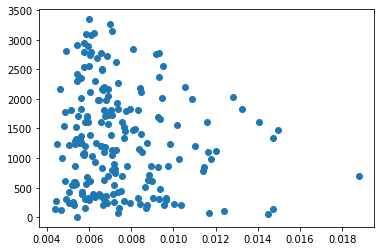

In [7]:
# Get scatter plot of distances
best_index = 1
best_result = all_results[best_index]
plt.scatter(dists_test, best_result)

In [8]:
# load final mlp models
from train import *
device = torch.device('cpu')
in_dim = 3
h_out = [20, 40, 60, 80]
h_layers = [6, 8, 10]
g_out = [10, 20, 30]
g_layers = [2, 3]
models = []
# (h_out, h_layers, g_out, g_layers)
model_params = []
for h in h_out:
    for hl in h_layers:
        for g in g_out:
            for gl in g_layers:
                model_params.append((h, hl, g, gl))
                model_name = generate_name(in_dim, h, g, hl, gl, True, 'sigmoid')
                PATH = '/data/sam/modelnet/models/mlp/1040/{modelname}'.format(modelname=model_name)
                model = PointNetLearner(in_dim, h, g, num_h_layers=hl, 
                            num_g_layers=gl, final_mlp=False, activation='sigmoid')
                model.load_state_dict(torch.load(PATH, map_location=device))
                models.append(model)

In [96]:
timing = []
for i in range(len(P_test)):
    P = P_test[i].to(device)
    Q = Q_test[i].to(device)
    start = time.time()
    estimate = model.get_full_result(P, Q)
    end = time.time()
    timing.append(end - start)
print("average", np.mean(timing), "std", np.std(timing))

average 0.09888561248779297 std 0.02563246031593887


In [9]:
all_results = []
average_errors = []
result_dictionary = {}
for params in model_params:
    hwidth = params[0]
    hdepth = params[1]
    result_dictionary[(hwidth, hdepth)] = []
for k in trange(len(models)):
    model = models[k]
    results = []
    model.eval()
    for i in range(len(P_test)):
        P = P_test[i].to(device)
        Q = Q_test[i].to(device)
        dist = dists_test[i]
        estimate = model.get_full_result(P, Q).detach().cpu().numpy()
        results.append(abs((1-estimate)- dist)/dist)
    all_results.append(results)
    avg_error = np.average(results)
    std = np.std(results)
    average_errors.append(avg_error)
    result_dictionary[(model_params[k][0], model_params[k][1])].append((model_params[k][2], model_params[k][3], avg_error, std))
    print("Model index:", k ,"Model parameters:", model_params[k], "Avg. error:", avg_error, "std:", std)
print("Lowest AVERAGE ERROR:", np.argmin(average_errors))

  3%|▎         | 2/72 [00:00<00:11,  6.04it/s]

Model index: 0 Model parameters: (20, 6, 10, 2) Avg. error: 114.80745 std: 28.735064
Model index: 1 Model parameters: (20, 6, 10, 3) Avg. error: 132.62729 std: 33.154636


  6%|▌         | 4/72 [00:00<00:10,  6.30it/s]

Model index: 2 Model parameters: (20, 6, 20, 2) Avg. error: 86.697 std: 21.903437
Model index: 3 Model parameters: (20, 6, 20, 3) Avg. error: 97.03904 std: 24.274458


  8%|▊         | 6/72 [00:00<00:10,  6.44it/s]

Model index: 4 Model parameters: (20, 6, 30, 2) Avg. error: 85.9708 std: 21.585787
Model index: 5 Model parameters: (20, 6, 30, 3) Avg. error: 103.93363 std: 25.97901


 10%|▉         | 7/72 [00:01<00:10,  6.03it/s]

Model index: 6 Model parameters: (20, 8, 10, 2) Avg. error: 115.29189 std: 28.810036


 12%|█▎        | 9/72 [00:01<00:11,  5.52it/s]

Model index: 7 Model parameters: (20, 8, 10, 3) Avg. error: 106.67257 std: 26.721926
Model index: 8 Model parameters: (20, 8, 20, 2) Avg. error: 133.70795 std: 33.41798


 15%|█▌        | 11/72 [00:01<00:11,  5.36it/s]

Model index: 9 Model parameters: (20, 8, 20, 3) Avg. error: 89.93863 std: 22.513388
Model index: 10 Model parameters: (20, 8, 30, 2) Avg. error: 79.99986 std: 20.072449


 17%|█▋        | 12/72 [00:02<00:11,  5.04it/s]

Model index: 11 Model parameters: (20, 8, 30, 3) Avg. error: 95.13563 std: 23.828493


 18%|█▊        | 13/72 [00:02<00:12,  4.85it/s]

Model index: 12 Model parameters: (20, 10, 10, 2) Avg. error: 80.407394 std: 20.195768


 19%|█▉        | 14/72 [00:02<00:12,  4.83it/s]

Model index: 13 Model parameters: (20, 10, 10, 3) Avg. error: 94.581894 std: 23.698448


 21%|██        | 15/72 [00:02<00:11,  4.80it/s]

Model index: 14 Model parameters: (20, 10, 20, 2) Avg. error: 87.95533 std: 21.161625


 22%|██▏       | 16/72 [00:03<00:12,  4.47it/s]

Model index: 15 Model parameters: (20, 10, 20, 3) Avg. error: 93.39752 std: 23.411129


 24%|██▎       | 17/72 [00:03<00:12,  4.57it/s]

Model index: 16 Model parameters: (20, 10, 30, 2) Avg. error: 95.36086 std: 23.476776


 26%|██▋       | 19/72 [00:03<00:10,  4.83it/s]

Model index: 17 Model parameters: (20, 10, 30, 3) Avg. error: 95.53795 std: 23.123384
Model index: 18 Model parameters: (40, 6, 10, 2) Avg. error: 95.89502 std: 24.038311


 28%|██▊       | 20/72 [00:03<00:10,  5.08it/s]

Model index: 19 Model parameters: (40, 6, 10, 3) Avg. error: 101.64788 std: 25.465334


 29%|██▉       | 21/72 [00:04<00:10,  4.87it/s]

Model index: 20 Model parameters: (40, 6, 20, 2) Avg. error: 97.083275 std: 24.312544


 32%|███▏      | 23/72 [00:04<00:09,  5.04it/s]

Model index: 21 Model parameters: (40, 6, 20, 3) Avg. error: 122.39652 std: 30.612726
Model index: 22 Model parameters: (40, 6, 30, 2) Avg. error: 138.68138 std: 34.653194


 33%|███▎      | 24/72 [00:04<00:09,  5.16it/s]

Model index: 23 Model parameters: (40, 6, 30, 3) Avg. error: 95.89923 std: 24.050539


 35%|███▍      | 25/72 [00:04<00:09,  4.87it/s]

Model index: 24 Model parameters: (40, 8, 10, 2) Avg. error: 123.3827 std: 30.857618


 36%|███▌      | 26/72 [00:05<00:09,  4.72it/s]

Model index: 25 Model parameters: (40, 8, 10, 3) Avg. error: 109.28987 std: 27.361391


 38%|███▊      | 27/72 [00:05<00:09,  4.62it/s]

Model index: 26 Model parameters: (40, 8, 20, 2) Avg. error: 103.428154 std: 25.907875


 39%|███▉      | 28/72 [00:05<00:09,  4.57it/s]

Model index: 27 Model parameters: (40, 8, 20, 3) Avg. error: 91.415955 std: 22.927008


 40%|████      | 29/72 [00:05<00:09,  4.58it/s]

Model index: 28 Model parameters: (40, 8, 30, 2) Avg. error: 129.94746 std: 32.496086


 42%|████▏     | 30/72 [00:05<00:09,  4.55it/s]

Model index: 29 Model parameters: (40, 8, 30, 3) Avg. error: 113.34894 std: 28.145622


 43%|████▎     | 31/72 [00:06<00:09,  4.32it/s]

Model index: 30 Model parameters: (40, 10, 10, 2) Avg. error: 113.411194 std: 28.384035


 44%|████▍     | 32/72 [00:06<00:09,  4.11it/s]

Model index: 31 Model parameters: (40, 10, 10, 3) Avg. error: 91.23796 std: 22.88286


 46%|████▌     | 33/72 [00:06<00:09,  4.00it/s]

Model index: 32 Model parameters: (40, 10, 20, 2) Avg. error: 99.648125 std: 24.971245


 47%|████▋     | 34/72 [00:07<00:09,  3.92it/s]

Model index: 33 Model parameters: (40, 10, 20, 3) Avg. error: 107.04618 std: 26.804771


 49%|████▊     | 35/72 [00:07<00:09,  3.87it/s]

Model index: 34 Model parameters: (40, 10, 30, 2) Avg. error: 105.39194 std: 26.382523


 50%|█████     | 36/72 [00:07<00:09,  3.81it/s]

Model index: 35 Model parameters: (40, 10, 30, 3) Avg. error: 95.786125 std: 24.013128


 51%|█████▏    | 37/72 [00:07<00:08,  4.01it/s]

Model index: 36 Model parameters: (60, 6, 10, 2) Avg. error: 100.46644 std: 25.172415


 53%|█████▎    | 38/72 [00:07<00:08,  4.20it/s]

Model index: 37 Model parameters: (60, 6, 10, 3) Avg. error: 107.12298 std: 26.82381


 54%|█████▍    | 39/72 [00:08<00:07,  4.26it/s]

Model index: 38 Model parameters: (60, 6, 20, 2) Avg. error: 116.09946 std: 29.050749


 56%|█████▌    | 40/72 [00:08<00:07,  4.37it/s]

Model index: 39 Model parameters: (60, 6, 20, 3) Avg. error: 95.17199 std: 23.858944


 57%|█████▋    | 41/72 [00:08<00:06,  4.52it/s]

Model index: 40 Model parameters: (60, 6, 30, 2) Avg. error: 87.36244 std: 21.921648


 58%|█████▊    | 42/72 [00:08<00:06,  4.60it/s]

Model index: 41 Model parameters: (60, 6, 30, 3) Avg. error: 97.132835 std: 24.333027


 60%|█████▉    | 43/72 [00:09<00:06,  4.43it/s]

Model index: 42 Model parameters: (60, 8, 10, 2) Avg. error: 118.944 std: 29.756445


 61%|██████    | 44/72 [00:09<00:07,  3.96it/s]

Model index: 43 Model parameters: (60, 8, 10, 3) Avg. error: 92.87919 std: 23.290123


 62%|██████▎   | 45/72 [00:09<00:06,  3.92it/s]

Model index: 44 Model parameters: (60, 8, 20, 2) Avg. error: 86.17198 std: 21.626171


 64%|██████▍   | 46/72 [00:09<00:06,  3.86it/s]

Model index: 45 Model parameters: (60, 8, 20, 3) Avg. error: 98.94232 std: 24.794302


 65%|██████▌   | 47/72 [00:10<00:06,  3.90it/s]

Model index: 46 Model parameters: (60, 8, 30, 2) Avg. error: 98.337006 std: 24.639782


 67%|██████▋   | 48/72 [00:10<00:06,  3.87it/s]

Model index: 47 Model parameters: (60, 8, 30, 3) Avg. error: 99.38616 std: 24.904415


 68%|██████▊   | 49/72 [00:10<00:06,  3.71it/s]

Model index: 48 Model parameters: (60, 10, 10, 2) Avg. error: 98.260155 std: 24.625069


 69%|██████▉   | 50/72 [00:11<00:06,  3.52it/s]

Model index: 49 Model parameters: (60, 10, 10, 3) Avg. error: 89.66974 std: 22.493904


 71%|███████   | 51/72 [00:11<00:06,  3.46it/s]

Model index: 50 Model parameters: (60, 10, 20, 2) Avg. error: 138.61201 std: 34.636017


 72%|███████▏  | 52/72 [00:11<00:05,  3.40it/s]

Model index: 51 Model parameters: (60, 10, 20, 3) Avg. error: 112.97326 std: 28.275185


 74%|███████▎  | 53/72 [00:11<00:05,  3.32it/s]

Model index: 52 Model parameters: (60, 10, 30, 2) Avg. error: 106.82963 std: 26.731457


 76%|███████▋  | 55/72 [00:12<00:04,  3.67it/s]

Model index: 53 Model parameters: (60, 10, 30, 3) Avg. error: 95.00542 std: 23.819464
Model index: 54 Model parameters: (80, 6, 10, 2) Avg. error: 107.76524 std: 26.983147


 78%|███████▊  | 56/72 [00:12<00:04,  3.92it/s]

Model index: 55 Model parameters: (80, 6, 10, 3) Avg. error: 110.54507 std: 27.672783


 79%|███████▉  | 57/72 [00:12<00:03,  4.16it/s]

Model index: 56 Model parameters: (80, 6, 20, 2) Avg. error: 95.56986 std: 23.957521


 81%|████████  | 58/72 [00:13<00:03,  4.34it/s]

Model index: 57 Model parameters: (80, 6, 20, 3) Avg. error: 74.80466 std: 18.531816


 82%|████████▏ | 59/72 [00:13<00:02,  4.35it/s]

Model index: 58 Model parameters: (80, 6, 30, 2) Avg. error: 100.470566 std: 25.173437


 83%|████████▎ | 60/72 [00:13<00:02,  4.42it/s]

Model index: 59 Model parameters: (80, 6, 30, 3) Avg. error: 99.50318 std: 24.933947


 85%|████████▍ | 61/72 [00:13<00:02,  4.29it/s]

Model index: 60 Model parameters: (80, 8, 10, 2) Avg. error: 90.036896 std: 22.584827


 86%|████████▌ | 62/72 [00:14<00:02,  4.16it/s]

Model index: 61 Model parameters: (80, 8, 10, 3) Avg. error: 94.8699 std: 23.783953


 88%|████████▊ | 63/72 [00:14<00:02,  4.08it/s]

Model index: 62 Model parameters: (80, 8, 20, 2) Avg. error: 88.604744 std: 22.229692


 89%|████████▉ | 64/72 [00:14<00:01,  4.00it/s]

Model index: 63 Model parameters: (80, 8, 20, 3) Avg. error: 115.536514 std: 28.911093


 90%|█████████ | 65/72 [00:14<00:01,  3.97it/s]

Model index: 64 Model parameters: (80, 8, 30, 2) Avg. error: 94.4817 std: 23.686369


 92%|█████████▏| 66/72 [00:15<00:01,  3.93it/s]

Model index: 65 Model parameters: (80, 8, 30, 3) Avg. error: 94.3226 std: 23.647524


 93%|█████████▎| 67/72 [00:15<00:01,  3.60it/s]

Model index: 66 Model parameters: (80, 10, 10, 2) Avg. error: 79.24252 std: 19.907057


 94%|█████████▍| 68/72 [00:15<00:01,  3.47it/s]

Model index: 67 Model parameters: (80, 10, 10, 3) Avg. error: 96.65371 std: 24.22673


 96%|█████████▌| 69/72 [00:16<00:00,  3.36it/s]

Model index: 68 Model parameters: (80, 10, 20, 2) Avg. error: 115.80783 std: 28.978403


 97%|█████████▋| 70/72 [00:16<00:00,  3.25it/s]

Model index: 69 Model parameters: (80, 10, 20, 3) Avg. error: 94.117676 std: 23.597376


 99%|█████████▊| 71/72 [00:16<00:00,  2.95it/s]

Model index: 70 Model parameters: (80, 10, 30, 2) Avg. error: 112.463554 std: 28.148733


100%|██████████| 72/72 [00:17<00:00,  4.17it/s]

Model index: 71 Model parameters: (80, 10, 30, 3) Avg. error: 99.658356 std: 24.971943
Lowest AVERAGE ERROR: 57


(200, 1)
(200,)
[[ 1.         -0.93315493]
 [-0.93315493  1.        ]]


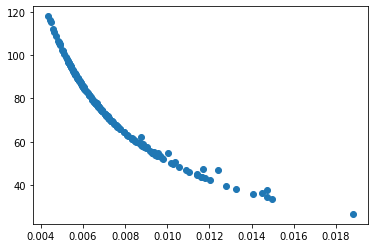

In [11]:
# Get scatter plot of distances
best_index = 57
best_result = np.array(all_results[best_index])
dists_test = np.array(dists_test)
print(best_result.shape)
print(dists_test.shape)
plt.scatter(dists_test, best_result)
r = np.corrcoef(dists_test,best_result[:, 0])
print(r)

In [99]:
# transform dataset for mlp
def transform_pcd_for_mlp(Ps, Qs, max_points=200):
    num_pcds = len(Ps)
    dim = Ps[0].shape[1]
    dataset = []
    szs = []
    #for i in range(len(Ps)):
    #    szs.append(len(Ps[i]))
    #print(np.max(szs))
    
    for i in range(num_pcds):
        vec = np.zeros((2 * max_points, dim + 1))
        P = Ps[i]
        Q = Qs[i]
        vec[:len(P), : dim] = P
        vec[:len(P), dim] = 1

        vec[:len(Q), : dim] = Q
        vec[:len(Q), dim] = 1
        dataset.append(vec)

    return dataset
vecs = transform_pcd_for_mlp(P_test, Q_test, max_points=5000)

In [97]:
hidden_dim = [ 80]
layers = [10]
in_dim = 2*200*4
models = []
for h in hidden_dim:
    for l in layers:
        PATH = '/data/sam/modelnet/models/vanilla/1040/hidden-dim-{dim}-layers-{layer}'.format(dim=h, layer=l)
        model = MLP(in_dim, h, l, activation='sigmoid')
        model.load_state_dict(torch.load(PATH, map_location=device))
        models.append(model)
        

In [100]:
timing = []
for i in range(len(vecs)):
    v = vecs[i].flatten()
    input_vec = torch.tensor(v, dtype=torch.float32).to(device)
    start = time.time()
    out = model.network(input_vec)
    end = time.time()
    timing.append(end - start)
print(np.mean(timing), np.std(timing))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x40000 and 1600x80)

In [68]:
all_results = []
average_errors = []
for k in trange(len(models)):
    model = models[k]
    results = []
    model.eval()
    for i in range(len(vecs)):
        v = vecs[i].flatten()
        input_vec = torch.tensor(v, dtype=torch.float32).to(device)
        out = model.network(input_vec).detach().numpy()
        #print(np.linalg.norm(pvec - qvec, ord=1), dist)
        dist = dists_test[i]
        results.append(abs(out- dist)/dist)
    all_results.append(results)
    avg_error = np.average(results)
    std = np.std(results)
    average_errors.append(avg_error)
    print("Model index:", k, "Average error:", avg_error, "std. dev:", std )
print("Lowest AVERAGE ERROR:", np.argmin(average_errors))

 33%|███▎      | 4/12 [00:00<00:00, 16.51it/s]

Model index: 0 Average error: 1.8346152 std. dev: 0.7003131
Model index: 1 Average error: 2.3012414 std. dev: 0.8155965
Model index: 2 Average error: 2.7071521 std. dev: 0.91587996
Model index: 3 Average error: 1.0472242 std. dev: 0.5035044


 67%|██████▋   | 8/12 [00:00<00:00, 16.38it/s]

Model index: 4 Average error: 0.47676608 std. dev: 0.30767322
Model index: 5 Average error: 0.9032716 std. dev: 0.46476486
Model index: 6 Average error: 0.696738 std. dev: 0.39753202
Model index: 7 Average error: 0.5957972 std. dev: 0.3592815


 83%|████████▎ | 10/12 [00:00<00:00, 16.03it/s]

Model index: 8 Average error: 0.72668356 std. dev: 0.4084772
Model index: 9 Average error: 0.3816113 std. dev: 0.25858563
Model index: 10 Average error: 0.41587842 std. dev: 0.27717087


100%|██████████| 12/12 [00:00<00:00, 15.61it/s]

Model index: 11 Average error: 0.28651744 std. dev: 0.19426703
Lowest AVERAGE ERROR: 11
